In [1]:
!pip install --user matplotlib --upgrade

Requirement already up-to-date: matplotlib in c:\users\s1905740\appdata\roaming\python\python37\site-packages (3.2.1)


In [2]:
# Import libraries
import csv
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy import linalg as la
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.spatial import distance
from scipy.special import comb, perm

In [3]:
sigma = 1
r = (1/sigma)*2**(1/6)
R = 6/(np.pi*sigma)*2**(1/6)
q1x = R
q1y = 0
q2x = (np.sqrt(3)/2)*R 
q2y = (1/2)*R
q3x = (1/2)*R
q3y = (np.sqrt(3)/2)*R 
q4x = 0
q4y = R
q5x = -(1/2)*R
q5y = (np.sqrt(3)/2)*R 
q6x = -(np.sqrt(3)/2)*R
q6y = (1/2)*R
q7x = -R
q7y = 0
q8x = -(np.sqrt(3)/2)*R
q8y = -(1/2)*R
q9x = -(1/2)*R
q9y = -(np.sqrt(3)/2)*R
q10x = 0
q10y = -R
q11x = (1/2)*R
q11y = -(np.sqrt(3)/2)*R
q12x = (np.sqrt(3)/2)*R
q12y = -(1/2)*R
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y,q4x,q4y,q5x,q5y,q6x,q6y,q7x,q7y,q8x,q8y,q9x,q9y,q10x,q10y,q11x,q11y,q12x,q12y])


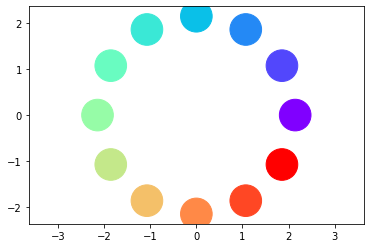

In [4]:
colors = cm.rainbow(np.linspace(0, 1, 12))
plt.scatter( q0[::2],q0[1::2],s=1000,color=colors) 
plt.axis('equal')
plt.show()

In [5]:
def phi_LJ(r):
    sigma = 1
    alpha = 1/12
    phi = alpha*((sigma/r)**12-(sigma/r)**6)
    return phi

In [6]:
def phi_spring(r):
    k=1
    r0 = 1
    phi = (1/2)*k*(r-r0)**2
    return phi

In [7]:
def U_LJ(q):
    N = int(len(q)/2)
    q_m = q.reshape((N, 2))
    U = 0
    for i in range(N-1):
        for j in np.arange(i+1, N+1):
            U = U + phi_LJ(la.norm(q_m[i,:]-q_m[j,:]))
    return U

In [8]:
def U_spring(q):
    N = int(len(q)/2)
    q_m = q.reshape((N, 2))
    U = 0
    for i in range(N-1):
        U = U + phi_spring(la.norm(q_m[i,:]))
    return U   
        

In [9]:
def U(q):
    return U_LJ(q)+U_spring(q)

In [10]:
def T(p):
    N = len(p)
    m = 1
    t = 0
    for i in range(N):
        t = t + la.norm(p)/2
    return t

In [11]:
def H(p,q):
    return T(p)+ U(Q)

In [12]:
def derivatives_LJ(q1,q2):
    
    r = np.linalg.norm( q1-q2 )
    
    energy = phi_LJ(r)
    
    
    q1x = q1[0] 
    q1y = q1[1]
    q2x = q2[0] 
    q2y = q2[1] 
    
    dU_dr = - 12 * r ** (-13) + 6 * r ** (-7)  
    
    dnorm_dq1x = (q1x-q2x)/r 
    dnorm_dq1y = (q1y-q2y)/r     
    dnorm_dq2x = (q2x-q1x)/r     
    dnorm_dq2y = (q2y-q1y)/r     
    
    dulj_dq1x = dU_dr * dnorm_dq1x
    dulj_dq1y = dU_dr * dnorm_dq1y
    dulj_dq2x = dU_dr * dnorm_dq2x
    dulj_dq2y = dU_dr * dnorm_dq2y
    
    return energy, dulj_dq1x, dulj_dq1y, dulj_dq2x, dulj_dq2y

In [13]:
def force_LJ(q1,q2):
    
    F1 = np.zeros_like(q1) 
    F2 = np.zeros_like(q2)
    
    energy, du_dq1x, du_dq1y, du_dq2x, du_dq2y = derivatives_LJ(q1,q2)
    
    F1[0] = -du_dq1x
    F1[1] = -du_dq1y
    F2[0] = -du_dq2x
    F2[1] = -du_dq2y
    
    return energy, F1, F2 

In [14]:
def total_force(q):
    N = int(len(q)/2)
    q_m = q.reshape((N, 2))
    com = int(comb(N, 2))
    e = np.zeros(com)
    f1 = np.zeros([com,2])
    f2 = np.zeros([com,2])
    f_m = np.zeros([N,N])
    f_a = np.zeros([N,N])
    for i in range(N-1):
        for j in np.arange(i+1, N):
            e[i],f1[i,:],f2[i,:] = force_LJ(q_m[i,:],q_m[j,:])
            f_m[i,j] = f1[i,0]
            f_m[j,i] = f2[i,0]
            f_a[i,j] = f1[i,1]
            f_a[j,i] = f2[i,1]
    pe = sum(e)
    f0 = f_m.sum(axis=1)
    f1 = f_a.sum(axis=1)
    c = np.vstack([f0,f1]).T
    f = c.reshape(len(q))
        
    return pe,f
    

In [15]:
def Eulers_Method(q,p,h, force_function):
    
    # Compute the force
    pe_old, f = force_function(q)
    
    # Do the update
    qt = q + h * p 
    pt = p + h * f
    
    # Compute the new energies
    pe, f_new = force_function(qt)
    ke = np.sum( pt*pt) / 2 
    
    # Total energy is kinetic + potential
    total_e = ke + pe 
    
    # Return values 
    return qt, pt, total_e

In [16]:
def run_simulation(q0, p0, Nsteps, h, step_function, force_function):
    
    # Initialize the output trajectories
    q_traj = [] 
    p_traj = [] 
    e_traj = [] 
    t_traj = []

    # Set initial conditions
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    # Main loop
    for n in range(Nsteps):
        
        # Step in time
        q,p,energy = step_function(q, p, h, force_function)
        t = t + h 

        # Save the system's data
        q_traj += [q] 
        p_traj += [p] 
        e_traj += [energy] 
        t_traj += [t] 

    # Format into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj) 

    # Return the trajectories
    return q_traj, p_traj, e_traj, t_traj

In [17]:
# Initialize momentum in R^24
p0 = np.random.randn( 24 ) * 0.25 

In [18]:
h = 0.025
T = 25
Nsteps = int(T/h)

q_traj, p_traj, e_traj, t_traj = run_simulation(q0, p0, Nsteps, h, Eulers_Method, total_force)

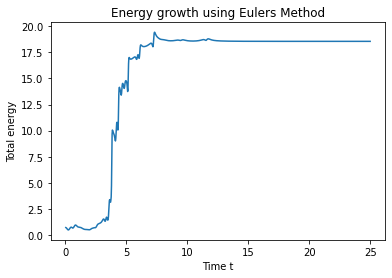

In [19]:
plt.plot( t_traj, e_traj )
plt.xlabel('Time t')
plt.ylabel('Total energy')
plt.title('Energy growth using Eulers Method')
plt.show()

In [20]:
def animate_trajectory(q_traj,skip=10,time_interval=50,colors = cm.rainbow(np.linspace(0, 1, 12))):
    # There are lots of ways to animate things in Python. This is 
    # a simple way of doing it.
    #
    # skip :: How many frames to skip
    # time_interval :: The time in ms between frames
    # colors :: A list of colours that we use for the particles
    
    frames = []   
    Nframes = int(len(q_traj)/skip) 
    
    for n in range(Nframes): 
        qq = q_traj[n*skip,:] 
        frame = plt.scatter( qq[::2],qq[1::2],s=250,edgecolor='k',c=colors)    

        frames.append( (frame,) )
    im_ani = animation.ArtistAnimation(plt.gcf(),frames,interval=time_interval);
    plt.close()
    return im_ani

In [21]:
# Create the animation
colors = cm.rainbow(np.linspace(0, 1, 12))
ani = animate_trajectory( q_traj)
# Display it in the notebook (as long as matplotlib is updated)
HTML(ani.to_jshtml())

In [22]:
def Verlet(q,p,h, force_function):
    
     # Compute the force
    pe_old, f = force_function(q)
    
    
    # Do the update 
    pt_1 = p + h/2 * f
    qt = q + h * pt_1
    
    # Compute the new energies
    pe, f_new = force_function(qt)
    pt = pt_1 + h/2 * f_new
    ke = np.sum( pt*pt) / 2 
    
    # Total energy is kinetic + potential
    total_e = ke + pe 
    
    # Return values 
    
    return qt, pt, total_e  

In [23]:
# Initialize momentum in R^24
p0 = np.random.randn( 24 ) * 0.25 

In [24]:
h = 0.025
T = 25
Nsteps = int(T/h)

q_traj, p_traj, e_traj, t_traj = run_simulation(q0, p0, Nsteps, h, Verlet, total_force)

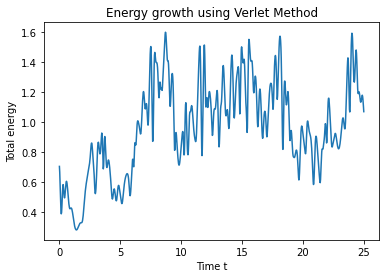

In [25]:
plt.plot( t_traj, e_traj )
plt.xlabel('Time t')
plt.ylabel('Total energy')
plt.title('Energy growth using Verlet Method')
plt.show()

In [26]:
def animate_trajectory(q_traj,skip=10,time_interval=50,colors = cm.rainbow(np.linspace(0, 1, 12))):
    # There are lots of ways to animate things in Python. This is 
    # a simple way of doing it.
    #
    # skip :: How many frames to skip
    # time_interval :: The time in ms between frames
    # colors :: A list of colours that we use for the particles
    
    frames = []   
    Nframes = int(len(q_traj)/skip) 
    
    for n in range(Nframes): 
        qq = q_traj[n*skip,:] 
        frame = plt.scatter( qq[::2],qq[1::2],s=250,edgecolor='k',c=colors)    

        frames.append( (frame,) )
    im_ani = animation.ArtistAnimation(plt.gcf(),frames,interval=time_interval);
    plt.close()
    return im_ani

In [27]:
# Create the animation
colors = cm.rainbow(np.linspace(0, 1, 12))
ani = animate_trajectory( q_traj)
# Display it in the notebook (as long as matplotlib is updated)
HTML(ani.to_jshtml())

In [28]:
# Simplified Takahashi-Imada
def S_T_I(q,p,h, force_function):
    
     # Compute the force
    alpha = 1/12
    pe_1, f1 = force_function(q)
    pe_2, f2 = force_function(q+alpha*h^2*f1)
    
    # Do the update 
    pt_1 = p + h/2 * f2
    qt = q + h * pt_1
    
    # Compute the new energies
    pe_3, f3 = force_function(qt)
    pe_4, f4 = force_function(qt + alpha*h^2*f3)
    pt = pt_1 + h/2 * f4
    ke = np.sum( pt*pt) / 2 
    
    # Total energy is kinetic + potential
    total_e = ke + pe_4 
    
    # Return values 
    
    return qt, pt, total_e  

In [34]:
# Initialize momentum in R^24
p0 = np.zeros( 24 )

In [35]:
h = 0.025
T = 25
Nsteps = int(T/h)

q_traj, p_traj, e_traj, t_traj = run_simulation(q0, p0, Nsteps, h, Verlet, total_force)

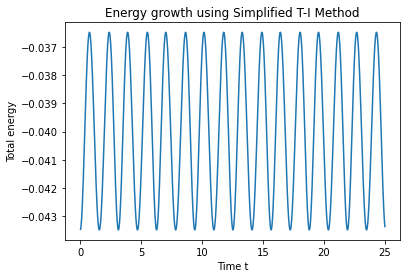

In [36]:
plt.plot( t_traj, e_traj )
plt.xlabel('Time t')
plt.ylabel('Total energy')
plt.title('Energy growth using Simplified T-I Method')
plt.show()

In [37]:
def animate_trajectory(q_traj,skip=10,time_interval=50,colors = cm.rainbow(np.linspace(0, 1, 12))):
    # There are lots of ways to animate things in Python. This is 
    # a simple way of doing it.
    #
    # skip :: How many frames to skip
    # time_interval :: The time in ms between frames
    # colors :: A list of colours that we use for the particles
    
    frames = []   
    Nframes = int(len(q_traj)/skip) 
    
    for n in range(Nframes): 
        qq = q_traj[n*skip,:] 
        frame = plt.scatter( qq[::2],qq[1::2],s=250,edgecolor='k',c=colors)    

        frames.append( (frame,) )
    im_ani = animation.ArtistAnimation(plt.gcf(),frames,interval=time_interval);
    plt.close()
    return im_ani

In [38]:
# Create the animation
colors = cm.rainbow(np.linspace(0, 1, 12))
ani = animate_trajectory( q_traj)
# Display it in the notebook (as long as matplotlib is updated)
HTML(ani.to_jshtml())